# Exploring Spatial Biases in Predictions

In this exercise, you will train a model and explore any spatial patterns in its prediction errors.

## Setup

First, the following cells import required Python modules and define some functions that will be useful for the analysis:

In [1]:
# Imports
%env MPLCONFIGDIR=/tmp/.cache
import os
import numpy as np
import rioxarray
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneGroupOut

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

env: MPLCONFIGDIR=/tmp/.cache


In [2]:
# Constants
DATA_DIRECTORY = '/home/jovyan/shared/NASA_Summer_School_2024/tree_mortality/materials/data'

# Spatial grid representation of data for reshaping and plotting results
SPATIAL_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_gridded_folds.nc4')

# Data files contain flattened, tabular representation of data for model training
DATA_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_gridded_training_nonzero.nc4')

TRAINING_VARIABLES = [
    'PR1-1', 'PRET1-1',
    'SPI1-1', 'SPI1-2', 'SPI1-3', 'SPI1-4','SPI1-5', 'SPI1-6',
    'SPEI1-1', 'SPEI1-2', 'SPEI1-3', 'SPEI1-4','SPEI1-5', 'SPEI1-6',
    'SPI2-1', 'SPI2-2', 'SPI2-3', 'SPI2-4','SPI2-5', 'SPI2-6',
    'SPEI2-1', 'SPEI2-2', 'SPEI2-3', 'SPEI2-4','SPEI2-5', 'SPEI2-6',
]

In [3]:
# Function Definitions

def filter_inf(X, y=None, fill=1e2):
    """
    Returns a version of the dataset in which infinite values have been
    replaced with a given finite fill value
    """
    if np.any(np.isnan(X)):
        raise ValueError('NaN entries present but not handled')
        
    Xnew = np.nan_to_num(X, neginf=-fill, posinf=fill)
    
    return Xnew if y is None else (Xnew, y)


def load_training_set(datafile, target='tpa'):
    """
    Loads a training dataset from the specified file, selecting a specific
    year if given.

    @param datafile: NetCDF4 data file path to load
    @param target: the target variable of the regression
        (default: tpa, trees per acre)

    @return (X, y, years, ids), where X is the feature matrix, y are the
        mortality labels, the years, and the grid cell ids
    """

    # Open dataset and select year (if specified)
    ds = xr.open_dataset(datafile)

    # Drop all variables except for the desired features
    X = ds[TRAINING_VARIABLES].to_array().T

    # Get target mortality values
    y = ds[target].as_numpy()

    # Filter infinite values
    X, y = filter_inf(X, y)

    # Get group definitions (years)
    years = ds.year.values.astype(int)

    # Get grid cell ids
    ids = ds['id'].values.astype(int)
    
    return X, y, years, ids


def reshape_results(spatial_ds, ids, y):
    """
    Reshapes a flattened predictions array into its original spatial grid
    using grid cell ids

    @param spatial_ds: xarray Dataset containing CRS and spatial grid info
    @param ids: grid cell ids corrsponding to values `y`
    @param y: values to reshape into the grid

    @return: `y` values reshaped into spatial grid
    """
    n = spatial_ds['id'].size
    shape = spatial_ds['id'].shape
    results = np.full(n, np.nan)
    results[ids] = y
    return results.reshape(shape, order='F').T


def plot_results(spatial_ds, ids, y_true, y_pred, vmax=10):
    """
    Plots the difference between true and predicted values

    @param spatial_ds: xarray Dataset containing CRS and spatial grid info
    @param ids: grid cell ids corrsponding to values `y`
    @param y_true: actual mortality values
    @param y_pred: predicted mortality values
    @param vmax: maximum difference value shown on plot (default: 10)
    """
    y_diff = y_pred - y_true
    Y_diff = reshape_results(spatial_ds, ids, y_diff)

    # Get coordinate reference system (CRS) for datasets
    crs = ccrs.Projection(spatial_ds.rio.crs)
    
    # Define CRS for plot
    proj = ccrs.AlbersEqualArea(
        central_longitude=-120, standard_parallels=(34, 40.5)
    )

    # Get spatial extent of grid
    extent=(
        np.min(spatial_ds.easting),
        np.max(spatial_ds.easting),
        np.min(spatial_ds.northing),
        np.max(spatial_ds.northing),
    )
    crs.bounds = extent

    fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(6, 8))
    ax.set_extent(extent, crs=crs)
    im = ax.imshow(Y_diff,
        extent=extent, transform=crs, origin='lower',
        vmin=-vmax, vmax=vmax, cmap='PiYG_r'
    )
    ax.set_facecolor('gray')
    ax.coastlines()
    ax.add_feature(cfeature.STATES.with_scale('10m'))
    cbar = plt.colorbar(im)
    cbar.set_label('Model Error [Predicted - Actual], trees/acre', fontsize=14)

## Analysis

The following cells provide an example that loads data, holds out a single study year, trains a model on the remaining years, and plots the difference between the predicted and actual values on a map. Replace the linear model with one of the other models you've trained as part of the previous exercise. You may also wish to modify the code to run the analysis across multiple study years.

In [4]:
# Load dataset for spatial grid definition
spatial_ds = xr.open_dataset(SPATIAL_FILE)

# Load the training set by year
X, y, years, ids = load_training_set(DATA_FILE)

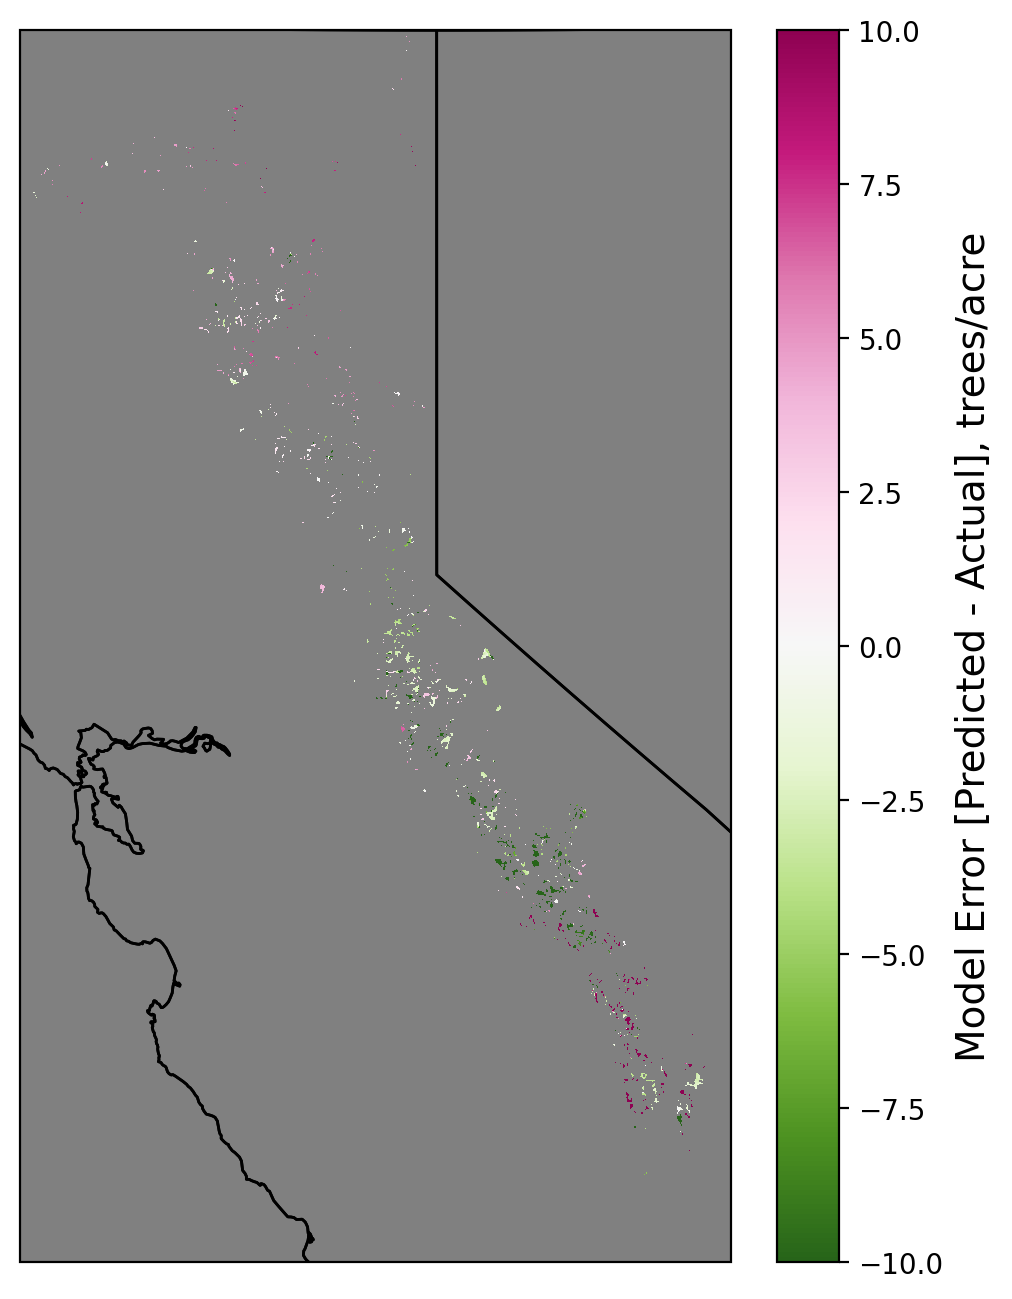

In [5]:
# Run analysis for a single study year
study_year = 2017

train_idx = (years != study_year)
test_idx = (years == study_year)

# TODO: replace with an alternative model
model = LinearRegression()

# Get predicted and true mortality values
model.fit(X[train_idx], y[train_idx])
y_pred = model.predict(X[test_idx])
y_true = y[test_idx]

plot_results(spatial_ds, ids[test_idx], y_true, y_pred)

## Questions

1. Do you observe any spatial bias in prediction errors?
2. If so, does the degree or pattern of bias change with model type and parameterization?
3. Does the pattern of bias change across years?
4. What factors might induce spatial bias in this dataset? How can these be mitigated?